In [3]:
import numpy as np
import pandas as pd
import os
import sys

#Path
try:
    current_dir = os.path.dirname(os.path.abspath(__file__))
except NameError:
    current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
xdrive_path = os.path.join(parent_dir, 'xdrive')
sys.path.append(xdrive_path)

pipeline_path = os.path.join(parent_dir, 'Pipeline')
sys.path.append(pipeline_path)

import get_files_from_xdrive as gxdrive

from build_a_pipeline import build_pipeline_P0_foward_price


In [4]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


In [ ]:
data['Avg_Settlement_Price_Lag7'] = data['Average_Settlement_Price_SE/CW(MWh)'].shift(7)
data['Avg_Settlement_Price_Lag30'] = data['Average_Settlement_Price_SE/CW(MWh)'].shift(30)

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = build_pipeline_P0_foward_price()


In [11]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regressor": SVR(),
    "Neural Network (MLP)": MLPRegressor(random_state=42, max_iter=1000)
}

# Function to evaluate models
def evaluate_models(models, X_train, y_train, X_val, y_val):
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_val_pred)
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        r2 = r2_score(y_val, y_val_pred)
        results.append({"Model": name, "MAE": mae, "RMSE": rmse, "R2": r2})
    return pd.DataFrame(results)

# Evaluate and display results
results = evaluate_models(models, X_train, y_train, X_val, y_val)
print(results)


                      Model        MAE        RMSE        R2
0         Linear Regression  13.871999   21.552437  0.979090
1          Ridge Regression   9.179808   16.475725  0.987781
2          Lasso Regression   8.765499   16.316703  0.988016
3             Random Forest   3.327054    8.602805  0.996669
4         Gradient Boosting   2.986503    8.149909  0.997010
5  Support Vector Regressor  61.289256  148.081752  0.012915
6      Neural Network (MLP)   8.875446   14.609080  0.990393


c:\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


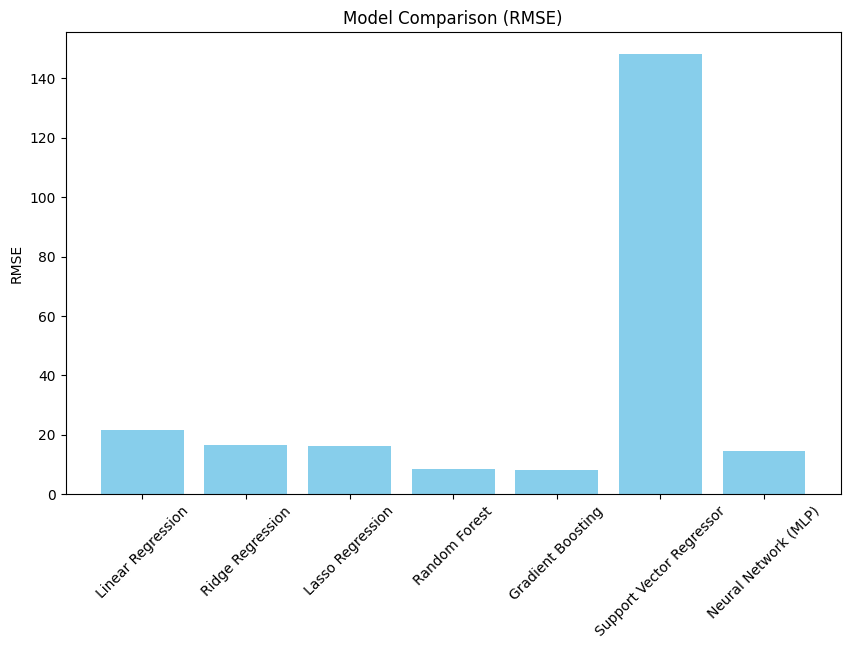

In [12]:
import matplotlib.pyplot as plt

# Plot RMSE for models
plt.figure(figsize=(10, 6))
plt.bar(results["Model"], results["RMSE"], color='skyblue')
plt.title("Model Comparison (RMSE)")
plt.ylabel("RMSE")
plt.xticks(rotation=45)
plt.show()


In [13]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV for Gradient Boosting
grid_gb = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_gb.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters for Gradient Boosting:", grid_gb.best_params_)
print("Best RMSE (Validation):", np.sqrt(-grid_gb.best_score_))


Fitting 3 folds for each of 162 candidates, totalling 486 fits


c:\Python312\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}
Best RMSE (Validation): 19.806522367427117


In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# GridSearchCV for Random Forest
grid_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Best parameters and performance
print("Best Parameters for Random Forest:", grid_rf.best_params_)
print("Best RMSE (Validation):", np.sqrt(-grid_rf.best_score_))


Fitting 3 folds for each of 162 candidates, totalling 486 fits
Best Parameters for Random Forest: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best RMSE (Validation): 22.65496842140558


In [15]:
# Gradient Boosting Evaluation
gb_best = grid_gb.best_estimator_
y_val_pred_gb = gb_best.predict(X_val)
print("Tuned Gradient Boosting:")
print("MAE:", mean_absolute_error(y_val, y_val_pred_gb))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred_gb)))
print("R2:", r2_score(y_val, y_val_pred_gb))

# Random Forest Evaluation
rf_best = grid_rf.best_estimator_
y_val_pred_rf = rf_best.predict(X_val)
print("Tuned Random Forest:")
print("MAE:", mean_absolute_error(y_val, y_val_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred_rf)))
print("R2:", r2_score(y_val, y_val_pred_rf))


Tuned Gradient Boosting:
MAE: 2.956091374268992
RMSE: 6.823835723601009
R2: 0.9979039175045292
Tuned Random Forest:
MAE: 3.3546666563651932
RMSE: 8.620509277203388
R2: 0.9966548384823928


In [17]:
# Gradient Boosting on Test Set
y_test_pred_gb = gb_best.predict(X_test)
print("Gradient Boosting (Test Set):")
print("MAE:", mean_absolute_error(y_test, y_test_pred_gb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_gb)))
print("R2:", r2_score(y_test, y_test_pred_gb))

# Random Forest on Test Set
y_test_pred_rf = rf_best.predict(X_test)
print("Random Forest (Test Set):")
print("MAE:", mean_absolute_error(y_test, y_test_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_rf)))
print("R2:", r2_score(y_test, y_test_pred_rf))


Gradient Boosting (Test Set):
MAE: 7.17981743242075
RMSE: 23.671569189570782
R2: 0.9731709305981437
Random Forest (Test Set):
MAE: 7.851126123250513
RMSE: 24.575304095386056
R2: 0.9710832611165688
